In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Load Dataset**

In [2]:
# Load Dataset
df = pd.read_csv('../data/IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    w1 = WordNetLemmatizer()

    soup = BeautifulSoup(text, 'html.parser') # Removing html page
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile('['
                             u'\U0001F600-\U0001F64F' # emoticons
                             u'\U0001F300-\U0001F5FF' # symbols & pictographs
                             u'\U0001F680-\U0001F6FF' # transport & map symbols
                             u'\U0001F1E0-\U0001F1FF' # flags (iOS)
                             u'\U00002702-\U000027B0'
                             u'\U000024C2-\U0001F251'
                             ']+', flags = re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after full stop
    text = re.sub(r'http\S+', '', text) # remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ".join([w1.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)   

C:\Users\LENOVO\AppData\Local\Temp/ipykernel_18244/2064046092.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # Removing html page


In [10]:
df

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


## **Data Analysis**

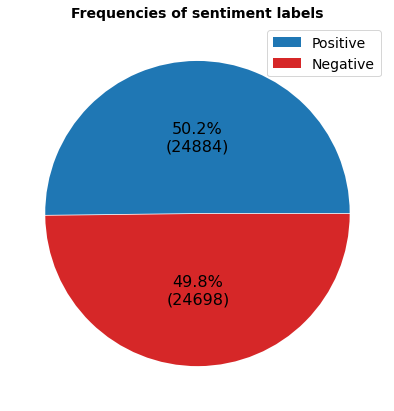

In [13]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize = [11, 7])
plt.gcf().set_facecolor('white')
plt.pie(x = data, autopct = lambda pct: func(pct, data), explode = [0.0025] * 2, 
        pctdistance = 0.5, colors = [sns.color_palette()[0], 'tab:red'], textprops = {'fontsize':16})
plt.title('Frequencies of sentiment labels', fontsize = 14, fontweight = 'bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc = 'best', prop = {'size':14})
plt.show()

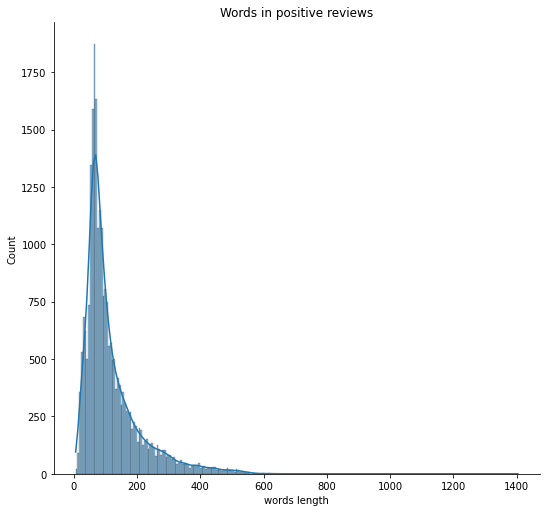

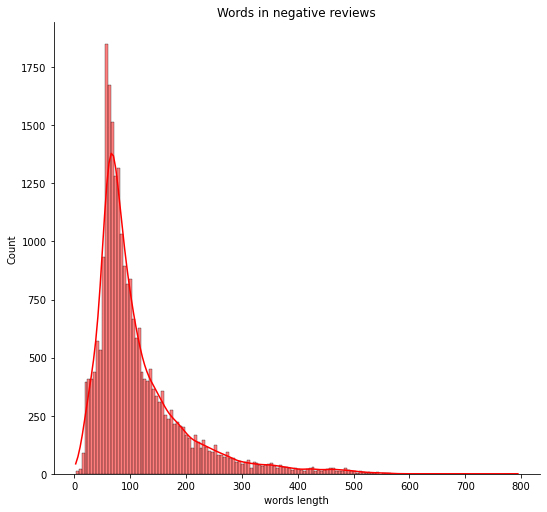

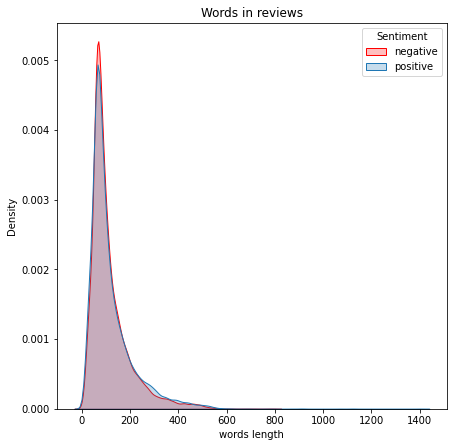

In [18]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'positive'], 
    x = 'words length', hue = 'sentiment', kde = True, height = 7, aspect = 1.1, legend = False
    ).set(title = 'Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'], 
    x = 'words length', hue = 'sentiment', kde = True, height = 7, aspect = 1.1, legend = False, palette = ['red']
    ).set(title = 'Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize = (7, 7.1))

kernel_distibution_number_words_plot = sns.kdeplot(
    data = df_temp, x = 'words length', hue = 'sentiment', fill = True, palette = [sns.color_palette()[0], 'red']
).set(title = 'Words in reviews')
plt.legend(title = 'Sentiment', labels = ['negative', 'positive'])
plt.show(kernel_distibution_number_words_plot)

## **Split the dataset into train and test sets**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
x_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size = 0.2, random_state = 42
)

## **Convert text into vectors**

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_features = 10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

## **Train and Evaluate model**

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

dt_classfier = DecisionTreeClassifier(
    criterion = 'entropy', random_state = 42
)
dt_classfier.fit(x_train_encoded, y_train)
y_pred = dt_classfier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7180598971463145

In [24]:
rf_classfier = RandomForestClassifier(
    random_state = 42
)
rf_classfier.fit(x_train_encoded, y_train)
y_pred = rf_classfier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8420893415347384

In [25]:
ada_classfier = AdaBoostClassifier(
    random_state = 42
)
ada_classfier.fit(x_train_encoded, y_train)
y_pred = ada_classfier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

c:\Users\LENOVO\anaconda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7930825854593123

In [26]:
gb_classfier = GradientBoostingClassifier(
    random_state = 42
)
gb_classfier.fit(x_train_encoded, y_train)
y_pred = gb_classfier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7968135524856307

In [27]:
xgb_classfier = xgb.XGBClassifier(
    random_state = 42
)
xgb_classfier.fit(x_train_encoded, y_train)
y_pred = xgb_classfier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8490470908540889